In [1]:
import os
from scipy.io import wavfile
import numpy as np
import sys
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from segment import extractTemporalFeatures,readFiles,addRandomNoise


In [2]:
directories = ["N","AS","MR","MS","MVP"]
label,data=readFiles(directories)
label,data=addRandomNoise(label,data,-22)

0.07943282347242814


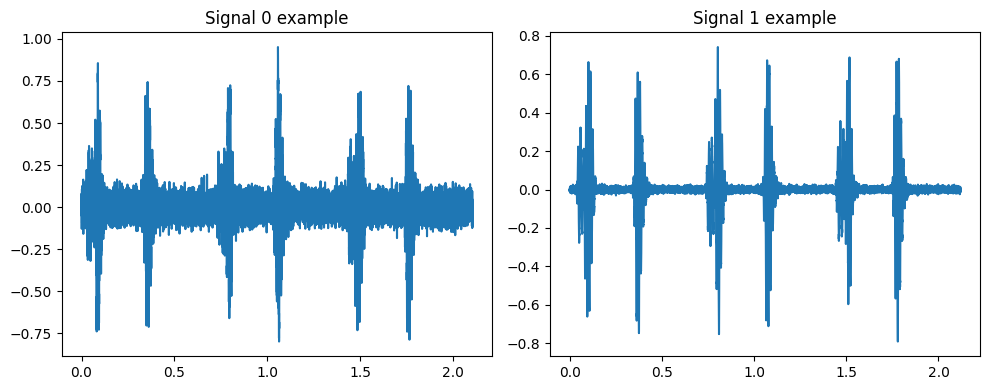

In [4]:
allZcr=[]
allEnergy=[]
allCentroid=[]
allMfccs=[]
allRolof=[]
allFlatness=[]
allLabels=[]
allAllLabels=[]
for i,track in enumerate(data):
    energy,zcr,centroid,rolof,flatness,mfccs=extractTemporalFeatures(track,frame_length=512,hop_length=256)
    allZcr.append(zcr)
    allEnergy.append(energy)
    allCentroid.append(centroid)
    allRolof.append(rolof)
    allFlatness.append(flatness)
    allMfccs.append(mfccs)
    allLabels.append(label[i])
    allAllLabels.append([label[i]] * energy.size)



fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
N = len(data[0])  
time = np.arange(N) / 8000
axes[0].plot(time,data[0])
axes[0].set_title("Signal 0 example")
N = len(data[1])  
time = np.arange(N) / 8000
axes[1].plot(time,data[1])
axes[1].set_title("Signal 1 example")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()
y = np.array(allLabels)





In [4]:
usedLabels=[]
allWindows=0
allUsed=0
for energy in allEnergy:
    a=np.array(energy>0.04).astype(int)
    usedLabels.append(a)
    allWindows+=energy.size
    allUsed+=sum(a[0])

In [5]:
print(f'number of Windows considered as silence: {allWindows-allUsed}')
print(f'total number of Windows: {allWindows}')

number of Windows considered as silence: 9209
total number of Windows: 38654


In [6]:


nonSilenceZcr=[]
nonSilenceCentroid=[]
nonSilenceRoloff=[]
nonSilenceMfccs=[]
nonSilenceFlatness=[]
for i,usedLabel in enumerate(usedLabels):
    nonSilenceZcr.append(allZcr[i][usedLabel==1])
    nonSilenceCentroid.append(allCentroid[i][usedLabel==1])
    nonSilenceRoloff.append(allRolof[i][usedLabel==1])
    nonSilenceFlatness.append(allFlatness[i][usedLabel==1])
    nonSilenceMfccs.append(allMfccs[i][:,usedLabel[0]==1])
    

In [7]:
allFeatures=[]
features = ["zcr","centroid","roloff","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]
classes=["N","AS","MR","MS","MVP"]
for i,lab in enumerate(allLabels):
    allFeatures.append(np.vstack([nonSilenceZcr[i],nonSilenceCentroid[i],nonSilenceRoloff[i],nonSilenceMfccs[i]]))

In [8]:
allFeatures[-1].shape

(23, 40)

In [9]:
mel_freqs = librosa.mel_frequencies(n_mels=20, fmin=0, fmax=8000//2)
print(mel_freqs)

[   0.          123.38161514  246.76323028  370.14484542  493.52646056
  616.9080757   740.28969083  863.67130597  987.05292111 1120.62723505
 1272.68537924 1445.37632487 1641.49974108 1864.2351847  2117.1936473
 2404.47609668 2730.73996177 3101.27463903 3522.08724425 4000.        ]


In [10]:
from sklearn.model_selection import train_test_split
dataTrain,dataTest,labelTrain,labelTest=train_test_split(allFeatures,allLabels,test_size=0.2,random_state=23,stratify=allLabels)

In [11]:
from sklearn.preprocessing import StandardScaler

allTrainData=np.concatenate(dataTrain,axis=1)
scaler = StandardScaler()
dataTrain_normalized = scaler.fit_transform(allTrainData.T)


In [12]:
allTrainLabels=[]
for id,lab in enumerate(labelTrain):
    allTrainLabels.extend([lab]*dataTrain[id].shape[1])

In [13]:
allTrainLabels=np.array(allTrainLabels)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
import time
k = 3  # Choose an appropriate k-value
knn = KNeighborsClassifier(n_neighbors=k)
start_time = time.perf_counter()
knn.fit(dataTrain_normalized, allTrainLabels)
end_time = time.perf_counter()

print(f'Elapsed Time in knn training: {end_time-start_time}')

Elapsed Time in knn training: 0.004056399999999627


In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,  random_state=42)


In [16]:
start_time = time.perf_counter()

rf.fit(dataTrain_normalized, allTrainLabels)
end_time = time.perf_counter()

print(f'Elapsed Time in RF training: {end_time-start_time}')

Elapsed Time in RF training: 11.4847014


In [17]:
import pandas as pd
feature_importance=rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print out the features and their importance
print(importance_df)

     Feature  Importance
7          5    0.059983
6          4    0.056580
19        17    0.051388
8          6    0.050897
18        16    0.049732
0        zcr    0.049081
3          1    0.048828
20        18    0.047527
17        15    0.043610
9          7    0.043138
5          3    0.042584
21        19    0.041810
13        11    0.041452
12        10    0.040957
11         9    0.040894
10         8    0.039315
22        20    0.038599
14        12    0.038576
4          2    0.038151
15        13    0.036145
1   centroid    0.035747
16        14    0.035729
2     roloff    0.029278


In [18]:
dataTrain_normalized[:,6]

array([ 0.03991357,  0.75040498, -0.21061558, ...,  0.64216226,
        1.06243442, -0.24564122])

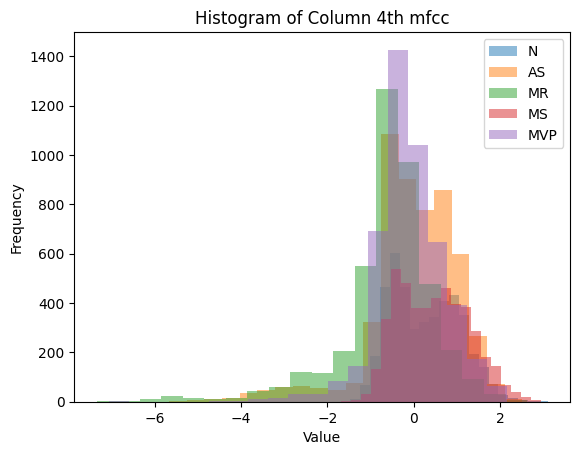

In [19]:

# Create a figure and axis
fig, ax = plt.subplots()
column_data=dataTrain_normalized[:,6]
# Loop through unique labels and plot each group with a different color
unique_labels = np.unique(allTrainLabels)
for label in unique_labels:
    # Filter data for the current label
    data_for_label = column_data[allTrainLabels == label]
    
    # Plot the histogram for this label
    ax.hist(data_for_label, bins=20, alpha=0.5, label=f'{classes[label]}')

# Add labels and title
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Column 4th mfcc')
ax.legend()

In [20]:
import joblib
joblib.dump(knn, "knn_model.pkl")

joblib.dump(rf, "rf_model.pkl")


['rf_model.pkl']

In [21]:
predictions = []
maxTIme=0
for dato in dataTest:
    start_time = time.perf_counter()
    predictions.append(knn.predict(scaler.transform(dato.T)))
    end_time = time.perf_counter()
    maxTIme=max(maxTIme,end_time-start_time)
print(f'Maximum Time in KNN prediction: {maxTIme}')

Maximum Time in KNN prediction: 0.11905330000000092


In [55]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(scaler.transform(dataTest[120].T), dataTrain_normalized)[0]  

In [42]:
dataTrain_normalized.shape

(23404, 23)

In [56]:
labelTrainmp = np.array(allTrainLabels)  # Only needs to be done once

nearest_indices = np.argsort(distances)[:3]
nearest_labels = labelTrainmp[nearest_indices]
nearest_distances = distances[nearest_indices]


In [ ]:
print("Test sample prediction:", knn.predict(scaler.transform(dataTest[120].T))[0])
print("Nearest neighbors (indices):", nearest_indices)
print("Labels of nearest neighbors:", nearest_labels)
print("Distances to neighbors:", nearest_distances)

Test sample prediction: 1
Nearest neighbors (indices): [13870 15863 11103]
Labels of nearest neighbors: [2 2 2]
Distances to neighbors: [2.8030049  3.18293846 3.22871822]


In [22]:
predictionsRf = []
maxTIme=0

for dato in dataTest:
    start_time = time.perf_counter()
    predictionsRf.append(rf.predict(scaler.transform(dato.T)))
    end_time = time.perf_counter()
    maxTIme=max(maxTIme,end_time-start_time)
print(f'Maximum Time in RF prediction: {maxTIme}')

Maximum Time in RF prediction: 0.019175900000000468


In [23]:
from collections import Counter

def most_frequent_element(arr):
    counts = Counter(arr)
    return counts.most_common(1)[0][0]

In [24]:
predictedLabels = [most_frequent_element(arr) for arr in predictions]
predictedLabelsRf = [most_frequent_element(arr) for arr in predictionsRf]



In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,f1_score

accuracy = accuracy_score(labelTest, predictedLabels)
print("Accuracy knn:", accuracy)
accuracyRf = accuracy_score(labelTest, predictedLabelsRf)
print("Accuracy random Forest:", accuracyRf)

accuracy = accuracy_score(labelTest, predictedLabels)
precision = precision_score(labelTest, predictedLabels,average='macro')
recall = recall_score(labelTest, predictedLabels,average='macro')
f1 = f1_score(labelTest, predictedLabels,average='macro')
print("Accuracy knn:", accuracy)
print("Precision knn:", precision)
print("Recall knn:", recall)
print("F1 Score knn:", f1)

accuracy = accuracy_score(labelTest, predictedLabelsRf)
precision = precision_score(labelTest, predictedLabelsRf,average='macro')
recall = recall_score(labelTest, predictedLabelsRf,average='macro')
f1 = f1_score(labelTest, predictedLabelsRf,average='macro')
print("Accuracy RF:", accuracy)
print("Precision RF:", precision)
print("Recall RF:", recall)
print("F1 Score RF:", f1)


print("Confusion Matrix knn:")
print(confusion_matrix(labelTest, predictedLabels))
print("Confusion Matrix Rf:")
print(confusion_matrix(labelTest, predictedLabelsRf))


Accuracy knn: 0.76
Accuracy random Forest: 0.785
Accuracy knn: 0.76
Precision knn: 0.8153296528033371
Recall knn: 0.76
F1 Score knn: 0.7533107563296242
Accuracy RF: 0.785
Precision RF: 0.81244727868264
Recall RF: 0.7849999999999999
F1 Score RF: 0.7804693974797068
Confusion Matrix knn:
[[38  2  0  0  0]
 [ 2 38  0  0  0]
 [ 3  0 34  3  0]
 [ 8  9  1 22  0]
 [15  1  3  1 20]]
Confusion Matrix Rf:
[[37  1  0  2  0]
 [ 3 37  0  0  0]
 [ 0  1 35  3  1]
 [ 7  7  0 26  0]
 [10  2  3  3 22]]


Text(0.5, 1.0, 'Confusion Matrix Noise KNN')

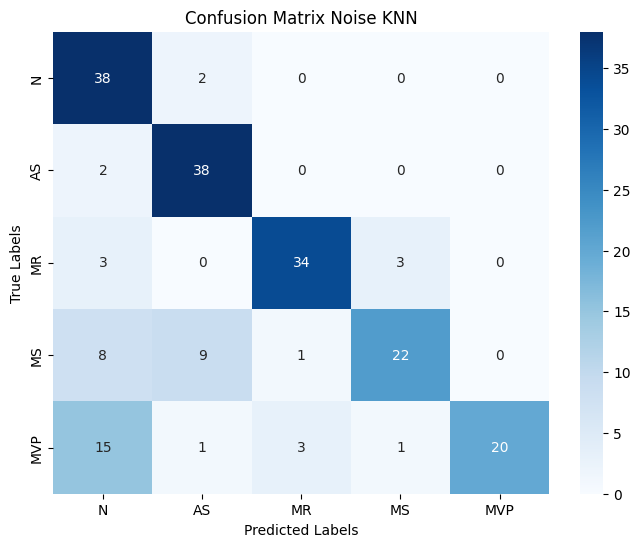

In [26]:
import seaborn as sns
cm = confusion_matrix(labelTest, predictedLabels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["N","AS","MR","MS","MVP"],  # Customize according to your classes
            yticklabels=["N","AS","MR","MS","MVP"])  # Customize according to your classes

# Labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Noise KNN')

#sembra funzionare bene. da pulire il codice

Magari vedere i tempi di entrambi per vedere effettivamente se questo è più semplice?

Per rendere explainable posso magari plottare la distribuzione di qualche parametro per ogni classe